# Extracting a pore network using PoreSpy and loading into OpenPNM


In [1]:
import warnings
import scipy as sp
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
ws = op.Workspace()
ws.settings["loglevel"] = 40
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(10)

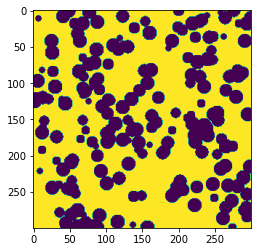

In [2]:
# NBVAL_IGNORE_OUTPUT
im = ps.generators.overlapping_spheres(shape=[300, 300, 300], radius=10, porosity=0.5, iter_max=0)
plt.imshow(im[:, :, 50]);

Let's check out the porosity of the generated image!

In [3]:
eps = ps.metrics.porosity(im)
print(f"Porosity: {eps*100:.1f}%")

Porosity: 61.9%


Let's visualize the image using `porespy`'s 3D visualizer: (this might take several seconds)

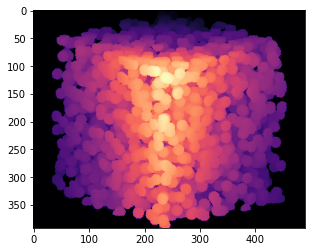

In [4]:
# NBVAL_IGNORE_OUTPUT
im_3d = ps.visualization.show_3D(im)
plt.imshow(im_3d, cmap=plt.cm.magma);

In [5]:
# NBVAL_IGNORE_OUTPUT
snow = ps.networks.snow(im=im, boundary_faces=['right'])

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  2296
Peaks after trimming saddle points:  1614
Peaks after trimming nearby peaks:  1569
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████████████████████████████████████████████████████████████████████| 1689/1689 [00:19<00:00, 85.26it/s]


In [6]:
net = op.network.GenericNetwork()
net.update(snow)
print(net)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.GenericNetwork : net_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.area                                      1689 / 1689 
2     pore.centroid                                  1689 / 1689 
3     pore.coords                                    1689 / 1689 
4     pore.diameter                                  1689 / 1689 
5     pore.equivalent_diameter                       1689 / 1689 
6     pore.extended_diameter                         1689 / 1689 
7     pore.inscribed_diameter                        1689 / 1689 
8     pore.label                                     1689 / 1689 
9     pore.surface_area                              1689 / 1689 
10    pore.volume                                    1689 / 1689

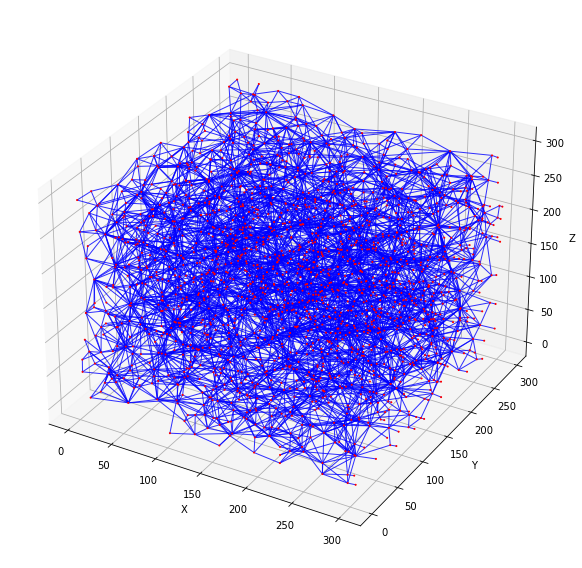

In [7]:
# NBVAL_IGNORE_OUTPUT
fig = op.topotools.plot_connections(network=net, alpha=0.8)
fig = op.topotools.plot_coordinates(network=net, fig=fig, color='r')
fig.set_size_inches(8, 8)
fig.tight_layout()

In [8]:
geo = op.geometry.Imported(net)

In [9]:
m = np.meshgrid(range(50, 250, 10), range(50, 295, 10))
m = np.vstack([-10*np.ones_like(m[1].flatten()), m[0].flatten(), m[1].flatten()]).T
op.topotools.find_surface_pores(network=net, markers=m, label='left')
op.topotools.clone_pores(network=net, pores=net.pores('left'), labels='left_boundary')
net['pore.coords'][net.pores('left_boundary')] *= [0, 1, 1]

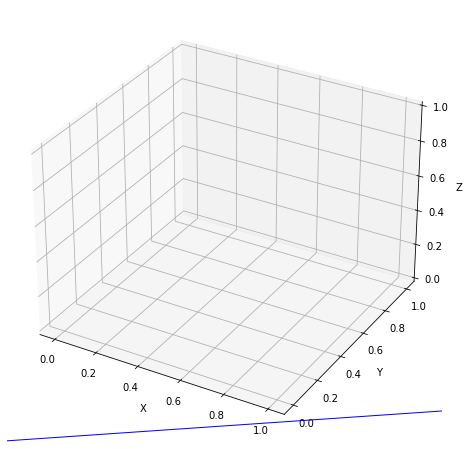

In [10]:
# NBVAL_IGNORE_OUTPUT
Ps = net.pores('boundary')
net.set_label('right_boundary', pores=Ps)
Ts = net.find_neighbor_throats(pores=net.pores('right_boundary'))
net.set_label('right_boundary', throats=Ts)
fig = op.topotools.plot_connections(network=net,
                                    throats=net.throats(['left_boundary', 'right_boundary']))
fig.set_size_inches(8, 8)

In [11]:
proj = net.project
for geo in proj.geometries().values():
    proj.purge_object(geo)

In [12]:
Ps = net.pores('left_boundary')
Ts = net.find_neighbor_throats(pores=Ps)
geo_bnd = op.geometry.StickAndBall(network=net, pores=Ps, throats=Ts)

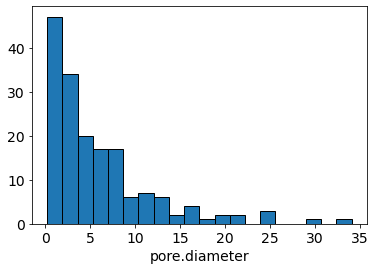

In [13]:
# NBVAL_IGNORE_OUTPUT
geo_bnd.show_hist('pore.diameter')